In [100]:
from datasets import load_dataset
import pandas as pd
from sklearn_crfsuite import CRF
import nltk
nltk.download()

NLTK Downloader
---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Command "'Enter'" unrecognized

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------
Command 'Download' unrecognized

-------------------------

    Error loading english: Package 'english' not found in index



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------

Download which package (l=list; x=cancel)?


    Error loading d: Package 'd' not found in index



---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------

Download which package (l=list; x=cancel)?


       | 
       | Downloading package abc to /Users/tina.vu/nltk_data...
       |   Unzipping corpora/abc.zip.
       | Downloading package alpino to /Users/tina.vu/nltk_data...
       |   Unzipping corpora/alpino.zip.
       | Downloading package averaged_perceptron_tagger to
       |     /Users/tina.vu/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger.zip.
       | Downloading package averaged_perceptron_tagger_ru to
       |     /Users/tina.vu/nltk_data...
       |   Unzipping taggers/averaged_perceptron_tagger_ru.zip.
       | Downloading package basque_grammars to
       |     /Users/tina.vu/nltk_data...
       |   Unzipping grammars/basque_grammars.zip.
       | Downloading package bcp47 to /Users/tina.vu/nltk_data...
       | Downloading package biocreative_ppi to
       |     /Users/tina.vu/nltk_data...
       |   Unzipping corpora/biocreative_ppi.zip.
       | Downloading package bllip_wsj_no_aux to
       |     /Users/tina.vu/nltk_data...
       |   Unzipp


---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------

---------------------------------------------------------------------------
    d) Download   l) List    u) Update   c) Config   h) Help   q) Quit
---------------------------------------------------------------------------

---------------------------------------------------------------------------
    d) Download   l) List  

True

In [109]:
from nltk.corpus import stopwords

en_stop_words = set(stopwords.words('english'))

In [110]:
dataset = load_dataset("jakartaresearch/semeval-absa", 'laptop')
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'text', 'aspects'],
        num_rows: 3048
    })
    validation: Dataset({
        features: ['id', 'text', 'aspects'],
        num_rows: 800
    })
})

In [111]:
dataset.set_format(type='pandas')
df = dataset['train'][:]
df.head()

,id,text,aspects
0,2339,I charge it at night and skip taking the cord ...,"{'term': ['cord', 'battery life'], 'polarity':..."
1,812,I bought a HP Pavilion DV4-1222nr laptop and h...,"{'term': [''], 'polarity': [''], 'from': [0], ..."
2,1316,The tech guy then said the service center does...,"{'term': ['service center', '""sales"" team', 't..."
3,2328,I investigated netbooks and saw the Toshiba NB...,"{'term': [''], 'polarity': [''], 'from': [0], ..."
4,2193,The other day I had a presentation to do for a...,"{'term': [''], 'polarity': [''], 'from': [0], ..."


In [112]:
df.drop_duplicates(subset=['text'], inplace=True)

In [113]:
def find_word_index(sentence, char_index):
    words = sentence.split()
    return next((i for i, word in enumerate(words) if (char_index - sum(len(w) + 1 for w in words[:i])) < len(word)), len(words) - 1)


def encode_BIO(x):
  '''
  This function puts aspect's details into a dictionary, and multiple aspect as an array
  
  Parameter:
  - ASPECTS: json array
    term: string array
    polarity: string array
    from: integer array
    to: integer array

    For example:
      {
        'term': ['cord', 'battery life'], 
        'polarity': ['neutral', 'positive'], 
        'from': [41, 74],
        'to': [45, 86]
      }
      
  Output:
  - PAIRS: dictionary array
    dictionary of
    - term
    - polarity
    - term_start
    - term_end

    For example:
    [
      {'term':'cord', 'polarity':'neutral', 'from': 41, 'to': 45},
      {'term':'battery life', 'polarity':'positive', 'from': 74, 'to': 86}
    ]
  '''
  pairs=list()
  aspects = x['aspects']
  text = x['text']
  text_token = text.split()
  l = len(aspects['term'])

  for i in range(0,l):
    pairs.append(dict({'term': aspects['term'][i]
                       ,'polarity':aspects['polarity'][i]
                       , 'term_start_char':aspects['from'][i]
                       , 'term_end_char':aspects['to'][i]-1
                       , 'term_start':find_word_index(text, aspects['from'][i])
                       , 'term_end':find_word_index(text, aspects['to'][i]-1)
                      }))
  
  aspect_encode = ['O'] * len(text_token)

  
  
  for k in pairs:
    aspect_encode = aspect_encode[:k['term_start']] + ['B'] + ['I'] * (k['term_end'] - k['term_start']) + aspect_encode[k['term_end'] + 1:]

  return pd.Series([pairs, text_token, aspect_encode])

In [145]:
df[['pairs','text_token', 'aspect_encode']] = df.apply(lambda x: encode_BIO(x), axis=1)
df['text_pos'] = df['text'].apply(lambda x: nltk.pos_tag(x.split()))
df['aspect_data'] = df.apply(lambda x: (x['text_token'], x['text_pos'], x['aspect_encode']), axis=1)
df.head()

,id,text,aspects,pairs,text_token,aspect_encode,text_pos,aspect_data
0,2339,I charge it at night and skip taking the cord ...,"{'term': ['cord', 'battery life'], 'polarity':...","[{'term': 'cord', 'polarity': 'neutral', 'term...","[I, charge, it, at, night, and, skip, taking, ...","[O, O, O, O, O, O, O, O, O, B, O, O, O, O, O, ...","[(I, PRP), (charge, VBP), (it, PRP), (at, IN),...","([I, charge, it, at, night, and, skip, taking,..."
1,812,I bought a HP Pavilion DV4-1222nr laptop and h...,"{'term': [''], 'polarity': [''], 'from': [0], ...","[{'term': '', 'polarity': '', 'term_start_char...","[I, bought, a, HP, Pavilion, DV4-1222nr, lapto...","[B, O, O, O, O, O, O, O, O, O, O, O, O, O, O, O]","[(I, PRP), (bought, VBD), (a, DT), (HP, NNP), ...","([I, bought, a, HP, Pavilion, DV4-1222nr, lapt..."
2,1316,The tech guy then said the service center does...,"{'term': ['service center', '""sales"" team', 't...","[{'term': 'service center', 'polarity': 'negat...","[The, tech, guy, then, said, the, service, cen...","[O, B, I, O, O, O, B, I, O, O, O, O, O, O, O, ...","[(The, DT), (tech, NN), (guy, NN), (then, RB),...","([The, tech, guy, then, said, the, service, ce..."
3,2328,I investigated netbooks and saw the Toshiba NB...,"{'term': [''], 'polarity': [''], 'from': [0], ...","[{'term': '', 'polarity': '', 'term_start_char...","[I, investigated, netbooks, and, saw, the, Tos...","[B, O, O, O, O, O, O, O]","[(I, PRP), (investigated, VBD), (netbooks, NNS...","([I, investigated, netbooks, and, saw, the, To..."
4,2193,The other day I had a presentation to do for a...,"{'term': [''], 'polarity': [''], 'from': [0], ...","[{'term': '', 'polarity': '', 'term_start_char...","[The, other, day, I, had, a, presentation, to,...","[B, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[(The, DT), (other, JJ), (day, NN), (I, PRP), ...","([The, other, day, I, had, a, presentation, to..."


In [146]:
# Function to convert sentences into features
def word2features(sent, i):
    word = sent[i][0]

    features = {
        'word.lower()': word.lower(), # word
        'word.pos': sent[i][1],
        'word.isstopword()': word in en_stop_words,
        'word[-3:]': word[-3:], # last 4 char
        'word[-2:]': word[-2:], # last 3 char - in case of -ing, -ion, etc.
        'word.isupper()': word.isupper(), # is the word in upper case
        'word.istitle()': word.istitle(), # is the first letter of the word in upper case
        'word.isdigit()': word.isdigit(), # is the word full of digit
    }
    if i > 0:
        prev_word = sent[i - 1][0]
        features.update({
            '-1:word.lower()': prev_word.lower(),
            '-1:word.pos': sent[i-1][1],
            '-1:word.isstopword()': prev_word in en_stop_words,
            '-1:word.istitle()': prev_word.istitle(),
            '-1:word.isupper()': prev_word.isupper(),
        })
    else:
        features['BOS'] = True  # Beginning of sentence

    if i < len(sent) - 1:
        next_word = sent[i + 1][0]
        features.update({
            '+1:word.lower()': next_word.lower(),
            '+1:word.pos': sent[i+1][1],
            '+1:word.isstopword()': next_word in en_stop_words,
            '+1:word.istitle()': next_word.istitle(),
            '+1:word.isupper()': next_word.isupper(),
        })
    else:
        features['EOS'] = True  # End of sentence

    return features

# Function to convert sentences into feature sequences
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

In [147]:
X_train = [[word2features(sentence, i) for i in range(len(sentence))] for sentence in df['text_pos']]
y_train = [sentence_labels for _,_, sentence_labels in df['aspect_data']]

In [148]:
# Create and train CRF model
crf_model = CRF(algorithm='lbfgs', c1=0.1, c2=0.1, max_iterations=100)
try:
  crf_model.fit(X_train, y_train)
except AttributeError:
  pass

In [149]:
dataset.set_format(type='pandas')
df_val= dataset['validation'][:]

df_val[['pairs','text_token', 'aspect_encode']] = df_val.apply(lambda x: encode_BIO(x), axis=1)
df_val['text_pos'] = df_val['text'].apply(lambda x: nltk.pos_tag(x.split()))
df_val['aspect_data'] = df_val.apply(lambda x: (x['text_token'], x['text_pos'], x['aspect_encode']), axis=1)

X_val = [[word2features(sentence, i) for i in range(len(sentence))] for sentence in df_val['text_pos']]
y_val = [sentence_labels for _,_, sentence_labels in df_val['aspect_data']]

In [143]:
# Test the model with new data
test_text = 'Boot time is super fast, around anywhere from 35 seconds to 1 minute.'
test_sentence =  nltk.pos_tag(test_text.split())
test_features = [word2features(test_sentence, i) for i in range(len(test_sentence))]
predicted_labels = crf_model.predict_single(test_features)

print("Predicted labels for the test sentence:", predicted_labels)

Predicted labels for the test sentence: ['B', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


In [132]:

df_validate.iloc[0]['text']

'Boot time is super fast, around anywhere from 35 seconds to 1 minute.'

In [144]:
df_validate.iloc[0]['aspects']

{'term': array(['Boot time'], dtype=object),
 'polarity': array(['positive'], dtype=object),
 'from': array([0], dtype=int16),
 'to': array([9], dtype=int16)}

421


(0.0, 1.0, 0.0, 1.0)

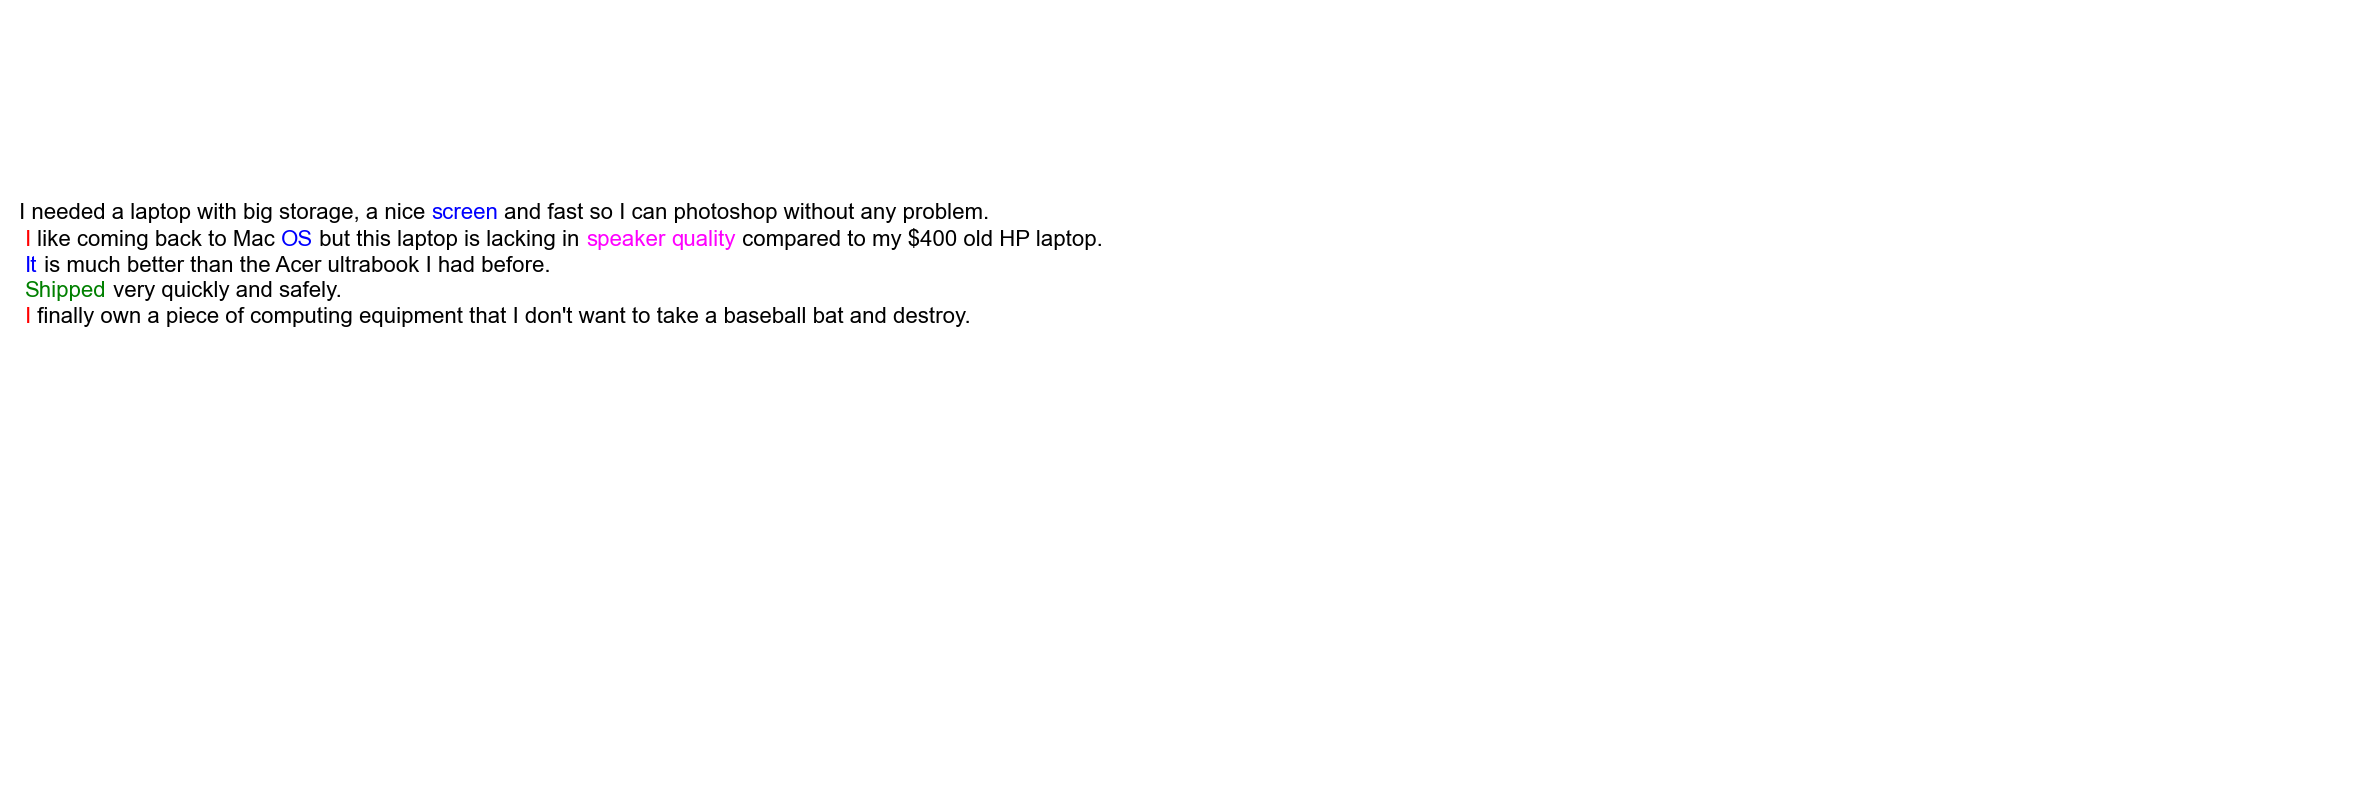

In [169]:
import matplotlib.pyplot as plt
import matplotlib
import random
from highlight_text import HighlightText, ax_text, fig_text

test = ' . '.join(df_val['text'])

fig, ax = plt.subplots(figsize=(30,10))
font = {'family' : 'arial',
        'size'   : 16}
matplotlib.rc('font', **font)
final_text = []
color = []
samples = 5
integer = random.randint(0,500)
prediction = crf_model.predict(X_val[integer:integer+samples])
print(integer)
for x,y in zip(df_val.iloc[integer:integer+samples]['text_token'], prediction):
    for x1,y1, in zip(x,y):
        if y1!='O':
            final_text.append('<{}>'.format(x1))
            if y1[0]=='I':
                color.append(color[-1])
            else:
                color.append ({'color':random.choice(['blue','green','red','magenta'])})
        else:
            final_text.append(x1)
    final_text.append('\n')
    # print(final_text)
# You can either create a HighlightText object
HighlightText(x=0, y=0.75,
              s=' '.join(final_text),
              highlight_textprops=color,
              ax=ax)
plt.axis('off')

In [178]:
n = 1
nth_sample = integer + n

print(df_val.iloc[nth_sample]['text'])
print(df_val.iloc[nth_sample]['aspects'])
print(prediction[n])

I like coming back to Mac OS but this laptop is lacking in speaker quality compared to my $400  old HP laptop.
{'term': array(['Mac OS', 'speaker quality'], dtype=object), 'polarity': array(['positive', 'negative'], dtype=object), 'from': array([22, 59], dtype=int16), 'to': array([28, 74], dtype=int16)}
['B', 'O', 'O', 'O', 'O', 'O', 'B', 'O', 'O', 'O', 'O', 'O', 'O', 'B', 'I', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
